In [12]:
import import_ipynb
import datetime
import pandas
from numpy import nan
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import dates as mdate
from IPython.display import Image
#pandas.options.display.float_format = '{:,.3f}'.format

# Soil moisture level shift detection
### brainstorm
* Interesting in moisture changes level instead of level itself
* Noise enviroment
 * apply moving average
 * change level threshold
* Monitoring sudden soil moisture sensors changes caused by:
 * rain (negative change level)
 * irrigation (negative change level)
 * hard sun (positive change level)
 * manual interventions (positive change level)
 * system malfuction (positive or negative change level)
* consider multiples sensors
 * consensus/voting?
 * sensor might not be sync
  * delays between change levels
  * time proximity
### referencies
* https://centre-borelli.github.io/ruptures-docs/
* https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/
* https://charles.doffy.net/files/sp-review-2020.pdf
* http://www.laurentoudre.fr/publis/TOG-SP-19.pdf

![title](./img/oasis_test_moisture.png)

In [13]:
# CONSTANTS

MOISTURES_PROBES = ['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX7']
ROLLING_WINDOW = 30 # RUPTURE_LEVEL_THRESHOLD and PCT_CHANGE_PERIOD are affected by this value
RUPTURE_LEVEL_THRESHOLD = 0.015
PCT_CHANGE_PERIOD = 10 # RUPTURE_LEVEL_THRESHOLD is affected by this value 

# UTILS

def plot(series): 
    plt.rcParams['figure.figsize'] = [15,7]
    plt.rcParams['timezone'] = 'America/Sao_Paulo'

    fig,ax = plt.subplots()
    x = mdate.epoch2num(series.index)
    fmt = mdate.DateFormatter('%y-%m-%d %H:%M')

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks( rotation=25 )
    plt.plot_date(x, series, linestyle='solid', marker='None')
    plt.legend(MOISTURES_PROBES)
    plt.show()

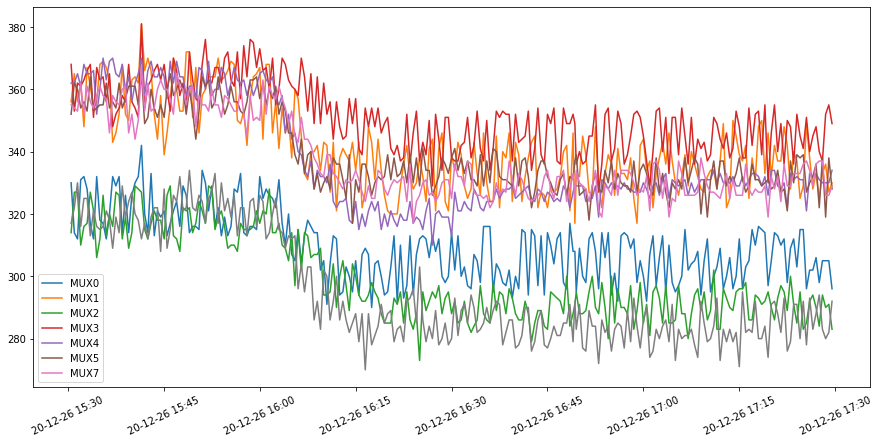

In [14]:
# RAW DATA FROM 2020-12-26 15:30 TO 2020-12-26 17;30
df = pandas.read_pickle('./detect_sudden_change_dataset.pkl')
plot(df)

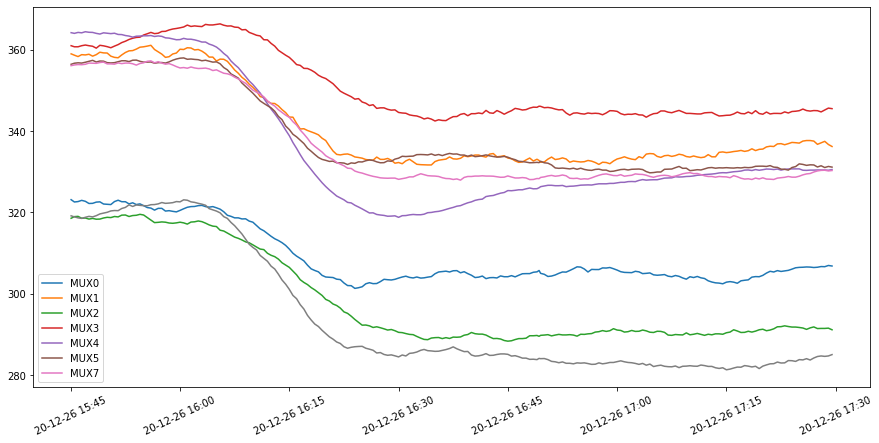

In [15]:
# Filtering the noise ...
dfr = df.rolling(ROLLING_WINDOW).mean().dropna()
plot(dfr)

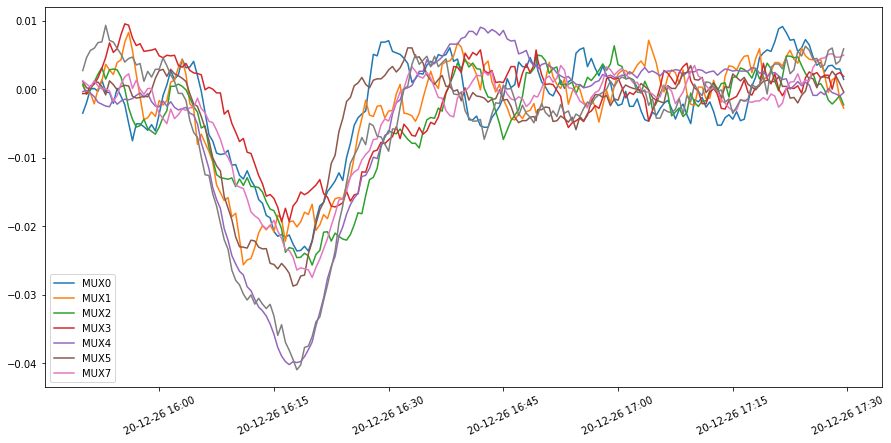

In [16]:
#Percentage change between the current and a prior element
# Finding negative or positive slopes ...
# percent change over given number of period.
pct_change_series = dfr.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
plot(pct_change_series)

In [17]:
# Looking the values ...
entries={}
for mux in MOISTURES_PROBES:
    entry={}
    entry['min_idx'] = pct_change_series[mux].idxmin()
    entry['min_value'] = pct_change_series[mux][entry['min_idx']]
    entry['min_time'] = datetime.datetime.fromtimestamp(entry['min_idx']).strftime('%Y-%m-%d %H:%M:%S')
    entry['max_idx'] = pct_change_series[mux].idxmax()
    entry['max_value'] = pct_change_series[mux][entry['max_idx']]
    entry['max_time'] = datetime.datetime.fromtimestamp(entry['max_idx']).strftime('%Y-%m-%d %H:%M:%S')
    entries[mux] = entry
data = pandas.DataFrame(data=entries).T # transpose
data

,min_idx,min_value,min_time,max_idx,max_value,max_time
MUX0,1609010370,-0.0236212,2020-12-26 16:19:30,1609014090,0.00914399,2020-12-26 17:21:30
MUX1,1609009860,-0.0256339,2020-12-26 16:11:00,1609008960,0.00828524,2020-12-26 15:56:00
MUX2,1609010400,-0.0256689,2020-12-26 16:20:00,1609012770,0.0063313,2020-12-26 16:59:30
MUX3,1609010160,-0.0193578,2020-12-26 16:16:00,1609008930,0.00952557,2020-12-26 15:55:30
MUX4,1609010220,-0.0401923,2020-12-26 16:17:00,1609011720,0.00903521,2020-12-26 16:42:00
MUX5,1609010250,-0.0287367,2020-12-26 16:17:30,1609011150,0.00602107,2020-12-26 16:32:30
MUX7,1609010280,-0.0409497,2020-12-26 16:18:00,1609008780,0.00930378,2020-12-26 15:53:00


In [23]:
def detect_rupture(data):
    # Filtering the noise ...
    data_filtered = data.rolling(ROLLING_WINDOW).mean().dropna()
    #Percentage change between the current and a prior element
    # Finding negative or positive slopes ...
    # percent change over given number of period.
    pct_change_series = data_filtered.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
    ### Gathering data
    ruptures={}
    min_probes={}
    max_probes={}
    for mux in MOISTURES_PROBES:
        min_entry={}
        min_entry['epoch'] = pct_change_series[mux].idxmin()
        min_entry['value'] = pct_change_series[mux][min_entry['epoch']]
        if min_entry['value'] < -RUPTURE_LEVEL_THRESHOLD:
            min_probes[mux] = min_entry

        max_entry={}
        max_entry['epoch'] = pct_change_series[mux].idxmax()
        max_entry['value'] = pct_change_series[mux][max_entry['epoch']]
        if max_entry['value'] > RUPTURE_LEVEL_THRESHOLD:
            max_probes[mux] = max_entry
    ruptures['negative'] = pandas.DataFrame(data=min_probes).T
    ruptures['positive'] =  pandas.DataFrame(data=max_probes).T
    return ruptures


ruptures = detect_rupture(df)
for type in ruptures:
    print(ruptures[type])
    print("-----")

             epoch     value
MUX0  1.609010e+09 -0.023621
MUX1  1.609010e+09 -0.025634
MUX2  1.609010e+09 -0.025669
MUX3  1.609010e+09 -0.019358
MUX4  1.609010e+09 -0.040192
MUX5  1.609010e+09 -0.028737
MUX7  1.609010e+09 -0.040950
-----
Empty DataFrame
Columns: []
Index: []
-----


# DARK SKY weather of 2020-12-26


URL: https://api.darksky.net/forecast/{key}/-23.535521,-46.763048,1609007400?units=si&lang=pt&exclude=currently,flags,daily

In [ ]:
darksky = {
   "latitude":-23.535521,
   "longitude":-46.763048,
   "timezone":"America/Sao_Paulo",
   "hourly":{
      "summary":"Chuva durante madrugada e noite.",
      "icon":"rain",
      "data":[
         {
            "time":1608951600,
            "summary":"Ligeiramente Nublado",
            "icon":"partly-cloudy-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":18.15,
            "apparentTemperature":18.15,
            "dewPoint":14.71,
            "humidity":0.8,
            "pressure":1014.2,
            "windSpeed":2.77,
            "windGust":5.8,
            "windBearing":149,
            "cloudCover":0.33,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":264.9
         },
         {
            "time":1608955200,
            "summary":"Limpo",
            "icon":"clear-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":17.55,
            "apparentTemperature":17.55,
            "dewPoint":14.43,
            "humidity":0.82,
            "pressure":1013.6,
            "windSpeed":2.6,
            "windGust":5.5,
            "windBearing":145,
            "cloudCover":0.31,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":264.4
         },
         {
            "time":1608958800,
            "summary":"Ligeiramente Nublado",
            "icon":"partly-cloudy-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":16.95,
            "apparentTemperature":16.95,
            "dewPoint":14.19,
            "humidity":0.84,
            "pressure":1013,
            "windSpeed":2.53,
            "windGust":5.23,
            "windBearing":140,
            "cloudCover":0.39,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":263.9
         },
         {
            "time":1608962400,
            "summary":"Ligeiramente Nublado",
            "icon":"partly-cloudy-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":16.64,
            "apparentTemperature":16.64,
            "dewPoint":14.09,
            "humidity":0.85,
            "pressure":1012.8,
            "windSpeed":2.47,
            "windGust":4.96,
            "windBearing":137,
            "cloudCover":0.42,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":263.6
         },
         {
            "time":1608966000,
            "summary":"Ligeiramente Nublado",
            "icon":"partly-cloudy-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":16.38,
            "apparentTemperature":16.38,
            "dewPoint":14.11,
            "humidity":0.86,
            "pressure":1012.8,
            "windSpeed":2.32,
            "windGust":4.73,
            "windBearing":137,
            "cloudCover":0.47,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":263.2
         },
         {
            "time":1608969600,
            "summary":"Ligeiramente Nublado",
            "icon":"partly-cloudy-night",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":16.82,
            "apparentTemperature":16.82,
            "dewPoint":14.11,
            "humidity":0.84,
            "pressure":1013,
            "windSpeed":2.11,
            "windGust":4.37,
            "windBearing":144,
            "cloudCover":0.51,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":261.9
         },
         {
            "time":1608973200,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.0051,
            "precipProbability":0.02,
            "precipType":"rain",
            "temperature":17.15,
            "apparentTemperature":17.15,
            "dewPoint":14.38,
            "humidity":0.84,
            "pressure":1013.1,
            "windSpeed":2.05,
            "windGust":3.98,
            "windBearing":145,
            "cloudCover":0.62,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":262.1
         },
         {
            "time":1608976800,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.006,
            "precipProbability":0.03,
            "precipType":"rain",
            "temperature":18.85,
            "apparentTemperature":18.87,
            "dewPoint":15.3,
            "humidity":0.8,
            "pressure":1013.4,
            "windSpeed":2.16,
            "windGust":3.94,
            "windBearing":137,
            "cloudCover":0.64,
            "uvIndex":1,
            "visibility":16.093,
            "ozone":263.2
         },
         {
            "time":1608980400,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.006,
            "precipProbability":0.04,
            "precipType":"rain",
            "temperature":21.15,
            "apparentTemperature":21.21,
            "dewPoint":15.97,
            "humidity":0.72,
            "pressure":1013.6,
            "windSpeed":2.32,
            "windGust":4.05,
            "windBearing":129,
            "cloudCover":0.67,
            "uvIndex":3,
            "visibility":16.093,
            "ozone":264.7
         },
         {
            "time":1608984000,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.0054,
            "precipProbability":0.04,
            "precipType":"rain",
            "temperature":22.68,
            "apparentTemperature":22.72,
            "dewPoint":16.02,
            "humidity":0.66,
            "pressure":1013.8,
            "windSpeed":2.53,
            "windGust":3.94,
            "windBearing":123,
            "cloudCover":0.7,
            "uvIndex":5,
            "visibility":16.093,
            "ozone":265.9
         },
         {
            "time":1608987600,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":23.99,
            "apparentTemperature":23.99,
            "dewPoint":15.45,
            "humidity":0.59,
            "pressure":1014,
            "windSpeed":2.35,
            "windGust":3.26,
            "windBearing":110,
            "cloudCover":0.73,
            "uvIndex":7,
            "visibility":16.093,
            "ozone":266.2
         },
         {
            "time":1608991200,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0,
            "precipProbability":0,
            "temperature":25.79,
            "apparentTemperature":25.81,
            "dewPoint":15.44,
            "humidity":0.53,
            "pressure":1013.4,
            "windSpeed":2.47,
            "windGust":2.47,
            "windBearing":119,
            "cloudCover":0.86,
            "uvIndex":7,
            "visibility":16.093,
            "ozone":266.1
         },
         {
            "time":1608994800,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.0093,
            "precipProbability":0.08,
            "precipType":"rain",
            "temperature":26.98,
            "apparentTemperature":27.43,
            "dewPoint":15.86,
            "humidity":0.51,
            "pressure":1011.8,
            "windSpeed":2.83,
            "windGust":2.83,
            "windBearing":97,
            "cloudCover":0.71,
            "uvIndex":8,
            "visibility":16.093,
            "ozone":266.1
         },
         {
            "time":1608998400,
            "summary":"Nublado",
            "icon":"partly-cloudy-day",
            "precipIntensity":0.0425,
            "precipProbability":0.09,
            "precipType":"rain",
            "temperature":27.54,
            "apparentTemperature":27.96,
            "dewPoint":16.23,
            "humidity":0.5,
            "pressure":1010.1,
            "windSpeed":2.95,
            "windGust":2.95,
            "windBearing":118,
            "cloudCover":0.86,
            "uvIndex":7,
            "visibility":16.093,
            "ozone":266
         },
         {
            "time":1609002000,
            "summary":"Muito Nublado",
            "icon":"cloudy",
            "precipIntensity":0.1198,
            "precipProbability":0.1,
            "precipType":"rain",
            "temperature":27.05,
            "apparentTemperature":27.6,
            "dewPoint":16.41,
            "humidity":0.52,
            "pressure":1009.6,
            "windSpeed":2.99,
            "windGust":2.99,
            "windBearing":144,
            "cloudCover":0.97,
            "uvIndex":6,
            "visibility":16.093,
            "ozone":266.2
         },
         {
            "time":1609005600,
            "summary":"Muito Nublado",
            "icon":"cloudy",
            "precipIntensity":0.2376,
            "precipProbability":0.13,
            "precipType":"rain",
            "temperature":25.26,
            "apparentTemperature":25.36,
            "dewPoint":16.5,
            "humidity":0.58,
            "pressure":1009.7,
            "windSpeed":3.08,
            "windGust":3.08,
            "windBearing":155,
            "cloudCover":0.95,
            "uvIndex":5,
            "visibility":16.093,
            "ozone":266.2
         },
         {
            "time":1609009200,
            "summary":"Muito Nublado",
            "icon":"cloudy",
            "precipIntensity":0.5215,
            "precipProbability":0.16,
            "precipType":"rain",
            "temperature":24.38,
            "apparentTemperature":24.56,
            "dewPoint":17.32,
            "humidity":0.65,
            "pressure":1009.8,
            "windSpeed":3.17,
            "windGust":3.36,
            "windBearing":133,
            "cloudCover":0.93,
            "uvIndex":3,
            "visibility":16.093,
            "ozone":266.2
         },
         {
            "time":1609012800,
            "summary":"Chuva",
            "icon":"rain",
            "precipIntensity":1.1151,
            "precipProbability":0.33,
            "precipType":"rain",
            "temperature":22.91,
            "apparentTemperature":23.2,
            "dewPoint":18.14,
            "humidity":0.74,
            "pressure":1010.2,
            "windSpeed":3.26,
            "windGust":4.98,
            "windBearing":100,
            "cloudCover":0.91,
            "uvIndex":1,
            "visibility":16.093,
            "ozone":266.2
         },
         {
            "time":1609016400,
            "summary":"Chuva",
            "icon":"rain",
            "precipIntensity":1.6425,
            "precipProbability":0.51,
            "precipType":"rain",
            "temperature":22.14,
            "apparentTemperature":22.48,
            "dewPoint":18.39,
            "humidity":0.79,
            "pressure":1010.6,
            "windSpeed":3.24,
            "windGust":6.06,
            "windBearing":183,
            "cloudCover":0.89,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":265.7
         },
         {
            "time":1609020000,
            "summary":"Chuva",
            "icon":"rain",
            "precipIntensity":1.479,
            "precipProbability":0.44,
            "precipType":"rain",
            "temperature":21.56,
            "apparentTemperature":21.95,
            "dewPoint":18.58,
            "humidity":0.83,
            "pressure":1011.2,
            "windSpeed":3.27,
            "windGust":6.29,
            "windBearing":101,
            "cloudCover":0.89,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":265.2
         },
         {
            "time":1609023600,
            "summary":"Chuva",
            "icon":"rain",
            "precipIntensity":1.0398,
            "precipProbability":0.39,
            "precipType":"rain",
            "temperature":21.16,
            "apparentTemperature":21.53,
            "dewPoint":18.37,
            "humidity":0.84,
            "pressure":1011.9,
            "windSpeed":3.36,
            "windGust":6.12,
            "windBearing":109,
            "cloudCover":0.83,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":264.9
         },
         {
            "time":1609027200,
            "summary":"Possível Chuva Fraca",
            "icon":"rain",
            "precipIntensity":0.742,
            "precipProbability":0.32,
            "precipType":"rain",
            "temperature":20.99,
            "apparentTemperature":21.34,
            "dewPoint":18.19,
            "humidity":0.84,
            "pressure":1012.9,
            "windSpeed":3.2,
            "windGust":5.98,
            "windBearing":120,
            "cloudCover":0.91,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":264.3
         },
         {
            "time":1609030800,
            "summary":"Possível Chuva Fraca",
            "icon":"rain",
            "precipIntensity":0.708,
            "precipProbability":0.28,
            "precipType":"rain",
            "temperature":20.85,
            "apparentTemperature":21.14,
            "dewPoint":17.74,
            "humidity":0.82,
            "pressure":1013.1,
            "windSpeed":3.14,
            "windGust":6.17,
            "windBearing":135,
            "cloudCover":0.92,
            "uvIndex":0,
            "visibility":16.093,
            "ozone":263.4
         },
         {
            "time":1609034400,
            "summary":"Chuva",
            "icon":"rain",
            "precipIntensity":1.0835,
            "precipProbability":0.39,
            "precipType":"rain",
            "temperature":20.56,
            "apparentTemperature":20.89,
            "dewPoint":17.94,
            "humidity":0.85,
            "pressure":1013.3,
            "windSpeed":2.2,
            "windGust":4.17,
            "windBearing":114,
            "cloudCover":0.96,
            "uvIndex":0,
            "visibility":6.176,
            "ozone":263.6
         }
      ]
   },
   "offset":-3
}